
# Diagnosing Chicken Diseases via Convolutional Neural Networks (CNN)
```
# This is formatted as code
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
zip_path = '/content/drive/My Drive/Chicken_disease-2.zip'
extraction_path = "/content/fecel_images-2"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [ ]:
healthy_dir = '/content/fecel_images-2/Chicken_disease-2/healthy'
salmo_dir = '/content/fecel_images-2/Chicken_disease-2/salmo'
cocci_dir = '/content/fecel_images-2/Chicken_disease-2/cocci'

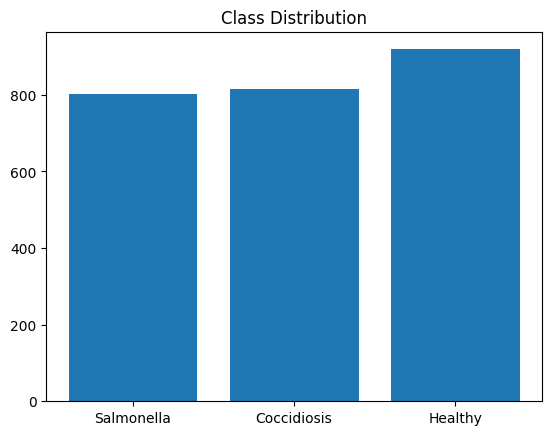

In [ ]:
class_counts = {
    'Salmonella': len(os.listdir(salmo_dir)),
    'Coccidiosis': len(os.listdir(cocci_dir)),
    'Healthy': len(os.listdir(healthy_dir))
}

plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.show()

In [ ]:
print(class_counts)

{'Salmonella': 803, 'Coccidiosis': 814, 'Healthy': 919}


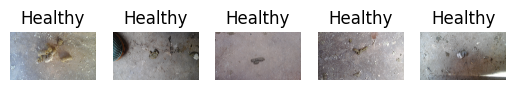

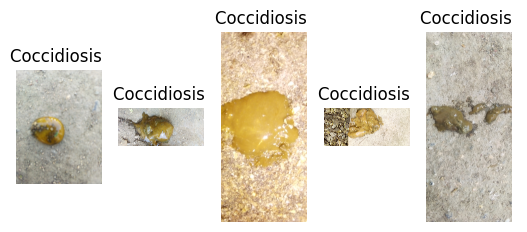

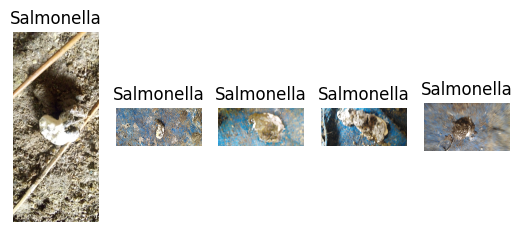

In [ ]:
# Load some example images
healthy_samples = [cv2.imread(os.path.join(healthy_dir, f)) for f in os.listdir(healthy_dir)[:5]]
cocci_samples = [cv2.imread(os.path.join(cocci_dir, f)) for f in os.listdir(cocci_dir)[:5]]
salmo_samples = [cv2.imread(os.path.join(salmo_dir, f)) for f in os.listdir(salmo_dir)[:5]]

# Show example images
for idx, img in enumerate(healthy_samples):
    plt.subplot(1, 5, idx+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Healthy')
    plt.axis('off')

plt.show()

for idx, img in enumerate(cocci_samples):
    plt.subplot(1, 5, idx+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Coccidiosis ')
    plt.axis('off')

plt.show()

for idx, img in enumerate(salmo_samples):
    plt.subplot(1, 5, idx+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Salmonella')
    plt.axis('off')

plt.show()

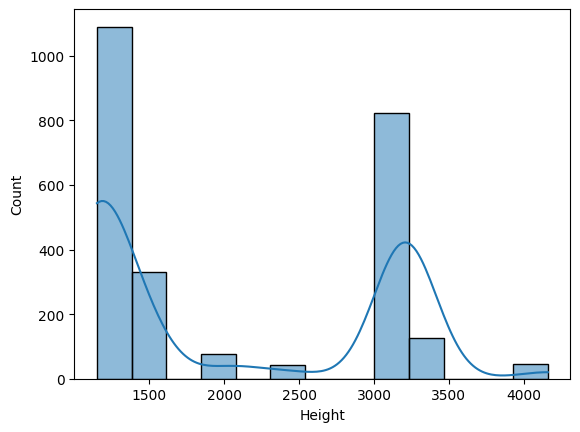

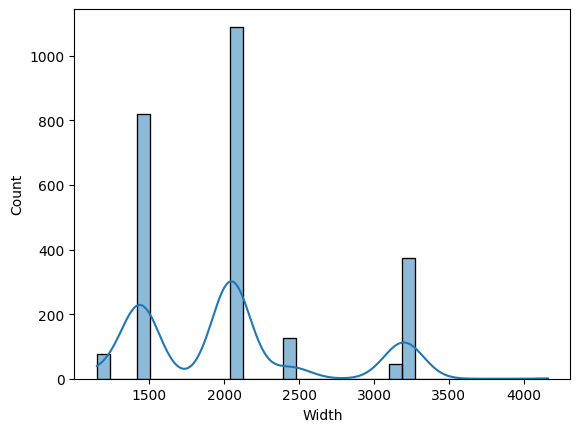

In [ ]:
image_dims = []

for f in os.listdir(healthy_dir):
    img = cv2.imread(os.path.join(healthy_dir, f))
    h, w, c = img.shape
    image_dims.append([h, w, c])

for f in os.listdir(cocci_dir):
    img = cv2.imread(os.path.join(cocci_dir, f))
    h, w, c = img.shape
    image_dims.append([h, w, c])

for f in os.listdir(salmo_dir):
    img = cv2.imread(os.path.join(salmo_dir, f))
    h, w, c = img.shape
    image_dims.append([h, w, c])

df_dims = pd.DataFrame(image_dims, columns=['Height', 'Width', 'Channel'])

sns.histplot(data=df_dims, x='Height', kde=True)


plt.show()

sns.histplot(data=df_dims, x='Width', kde=True)
plt.show()

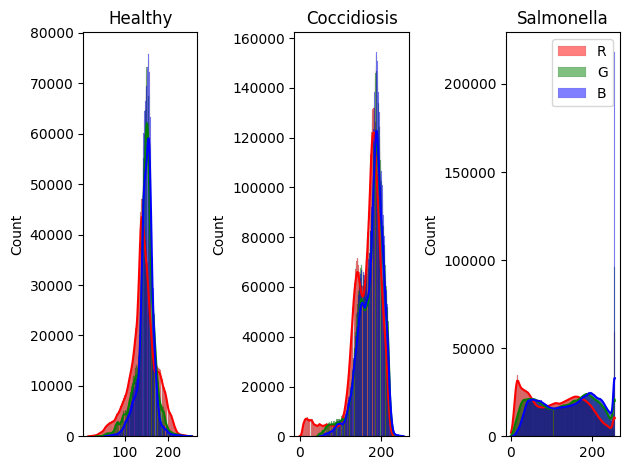

In [ ]:
# Choose one example from each category
healthy_example = cv2.imread(os.path.join(healthy_dir, os.listdir(healthy_dir)[0]))
cocci_example = cv2.imread(os.path.join(cocci_dir, os.listdir(cocci_dir)[0]))
salmo_example = cv2.imread(os.path.join(salmo_dir, os.listdir(salmo_dir)[0]))

# Plot color histogram
colors = ('r', 'g', 'b')

for i, color in enumerate(colors):
    # Healthy plot
    plt.subplot(1, 3, 1)
    plt.title('Healthy')
    sns.histplot(healthy_example[:,:,i].ravel(), color=color, kde=True, bins=256, label=color.upper())

    # Coccidiosis plot
    plt.subplot(1, 3, 2)
    plt.title('Coccidiosis')
    sns.histplot(cocci_example[:,:,i].ravel(), color=color, kde=True, bins=256, label=color.upper())

    # Salmonella plot
    plt.subplot(1, 3, 3)
    plt.title('Salmonella')
    sns.histplot(salmo_example[:,:,i].ravel(), color=color, kde=True, bins=256, label=color.upper())

plt.legend()
plt.tight_layout()
plt.show()

## Removing Corrupted Images

In [ ]:
def remove_corrupted_images(directory_path):
    """
    Removes corrupted images from the specified directory.

    Args:
    - directory_path (str): Path to the directory containing the images.

    Returns:
    - List of filenames that were corrupted and removed.
    """

    corrupted_files = []

    for filename in os.listdir(directory_path):
        filepath = os.path.join(directory_path, filename)

        # Try reading the image
        img = cv2.imread(filepath)

        if img is None or img.shape[0] == 0 or img.shape[1] == 0:
            # The image is corrupted
            print(f"Removing corrupted image: {filepath}")
            os.remove(filepath)
            corrupted_files.append(filename)

    return corrupted_files
corrupted_images_healthy = remove_corrupted_images(healthy_dir)
corrupted_images_cocci = remove_corrupted_images(cocci_dir)
corrupted_images_salmo = remove_corrupted_images(salmo_dir)

print(f"Removed {len(corrupted_images_healthy)} corrupted images health.")
print(f"Removed {len(corrupted_images_cocci)} corrupted images Cocci.")
print(f"Removed {len(corrupted_images_salmo)} corrupted images Salmo.")

Removed 0 corrupted images health.
Removed 0 corrupted images Cocci.
Removed 0 corrupted images Salmo.


## Preprocessing Techniques

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set a target size for resizing and batch size
target_size = (300, 300)
batch_size = 32

# Initialize ImageDataGenerator with normalization and augmentation options
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    fill_mode='nearest',
    validation_split=0.2   # setting aside 20% of the data for validation
)

# Correct root directory path
root_dir = '/content/fecel_images-2/Chicken_disease-2'

# Create generators for training and validation sets
train_generator = datagen.flow_from_directory(
    directory=root_dir,
    shuffle=True,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # Updated to 'categorical' for multi-class classification
    subset='training'  # use the training subset of the data
)

validation_generator = datagen.flow_from_directory(
    directory=root_dir,
    shuffle=False,  # Ensure consistent order
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # Updated to 'categorical'
    subset='validation'  # use the validation subset of the data
)

Found 2031 images belonging to 3 classes.
Found 505 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(3, activation='softmax')  # Multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training with Early Stopping

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 5

# Set up early stopping callback
# This will monitor 'val_loss' and stop training if it doesn't improve for 4 consecutive epochs.

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stop]  # Added the early stopping and checkpoint callback
)

Epoch 1/5
63/63 [==============================] - 169s 2s/step - loss: 1.0984 - accuracy: 0.6243 - val_loss: 0.4998 - val_accuracy: 0.8417
Epoch 2/5
63/63 [==============================] - 154s 2s/step - loss: 0.4167 - accuracy: 0.8524 - val_loss: 0.4411 - val_accuracy: 0.8271
Epoch 3/5
63/63 [==============================] - 145s 2s/step - loss: 0.3666 - accuracy: 0.8594 - val_loss: 0.3757 - val_accuracy: 0.8687
Epoch 4/5
63/63 [==============================] - 146s 2s/step - loss: 0.4342 - accuracy: 0.8274 - val_loss: 0.4504 - val_accuracy: 0.8417
Epoch 5/5
63/63 [==============================] - 145s 2s/step - loss: 0.3410 - accuracy: 0.8794 - val_loss: 0.5203 - val_accuracy: 0.8438


In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

16/16 [==============================] - 27s 2s/step - loss: 0.5320 - accuracy: 0.8475
Validation Loss: 0.5320
Validation Accuracy: 0.8475


## Get True and Predicted Labels:

In [ ]:
# Get the true labels
true_labels = validation_generator.classes

# Predict labels for the validation set
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

16/16 [==============================] - 26s 2s/step


## Compute and Display the Confusion Matrix:

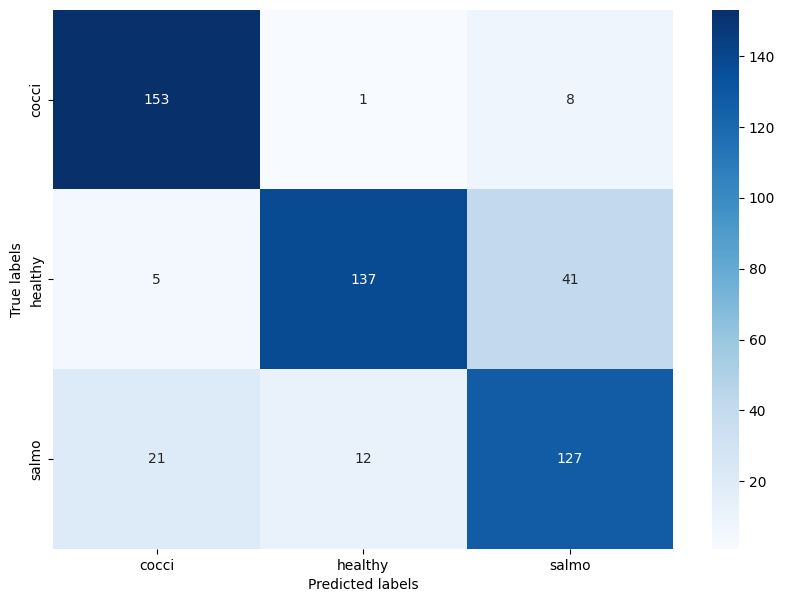

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=validation_generator.class_indices, yticklabels=validation_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Compute Precision, Recall, and F1 Score:

In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=validation_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       cocci       0.85      0.94      0.90       162
     healthy       0.91      0.75      0.82       183
       salmo       0.72      0.79      0.76       160

    accuracy                           0.83       505
   macro avg       0.83      0.83      0.83       505
weighted avg       0.83      0.83      0.83       505



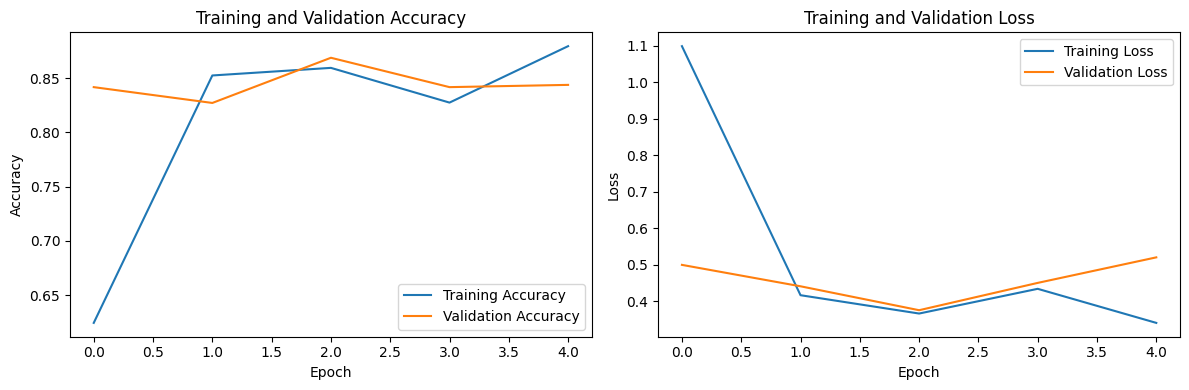

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Get the filename (assuming you uploaded only one file)
filename = list(uploaded.keys())[0]

img = image.load_img(filename, target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize to [0,1]

In [ ]:
# Let's say the default mapping is:
default_mapping = {'healthy': 0, 'salmo': 1, 'cocci': 2}

# And you want to change it to:
custom_mapping = {0: 'Healthy Chicken', 1: 'Salmonella Infected', 2: 'Coccidiosis Infected'}

# When you get a prediction:
predicted_class = np.argmax(predictions[0])
predicted_class_name = custom_mapping[predicted_class]
print(f"Predicted class: {predicted_class_name}")

Predicted class: Healthy Chicken


16/16 [==============================] - 25s 2s/step


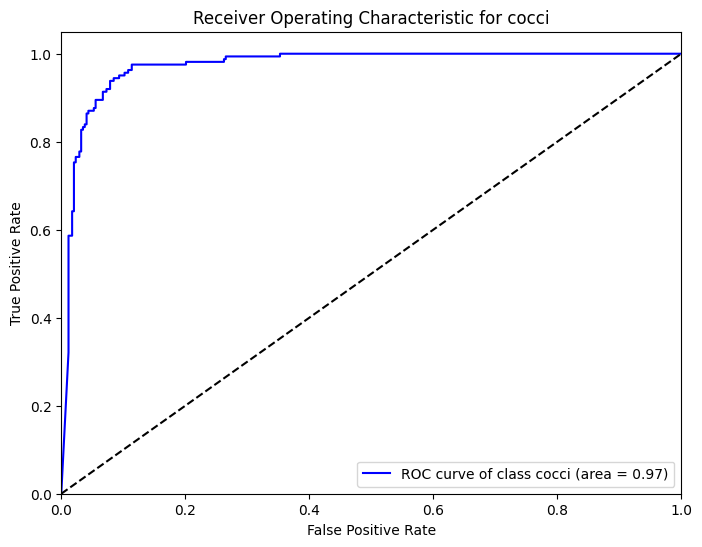

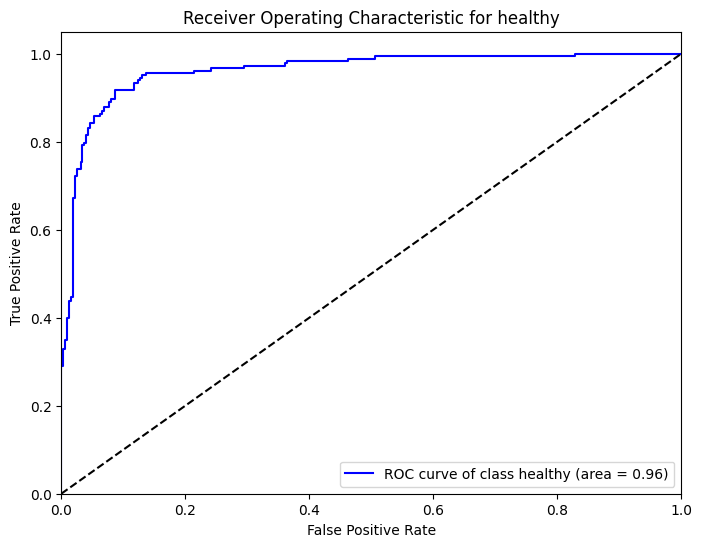

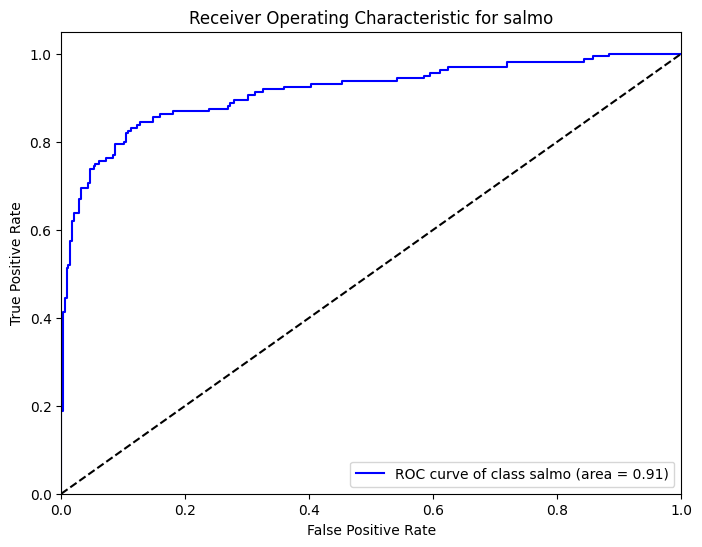

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Convert the labels from integers to one-hot encoded format
lb = LabelBinarizer()
true_labels_onehot = lb.fit_transform(true_labels)
predicted_scores = model.predict(validation_generator)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = 3

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], predicted_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves separately for each class
for i, label in enumerate(validation_generator.class_indices.keys()):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})', color='b')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {label}')
    plt.legend(loc="lower right")
    plt.show()


### Common ROC Curve:

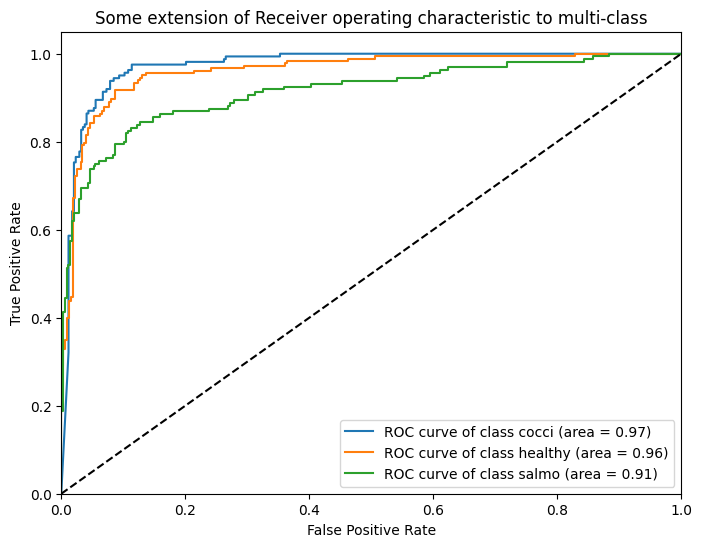

In [ ]:

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, label in enumerate(validation_generator.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()